In [196]:
import pandas as pd 
import geopandas as gpd 
from shapely import Polygon
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt

In [197]:
# create four polygons, 2x2 squares within the bounds listed 

corners = [(77.99740989047633+0.01, 21.407915213344708+0.01),
        (78.09242119966183-0.01, 21.407915213344708+0.01),
        (78.09242119966183-0.01, 21.502259065820887-0.01),
        (77.99740989047633+0.01, 21.502259065820887-0.01)]

x_tl, y_tl = corners[0]
x_tr, y_tr = corners[1]
x_br, y_br = corners[2]
x_bl, y_bl = corners[3]

top_left = (x_tl, y_tl)
top_right = (x_tr, y_tr)
bottom_right = (x_br, y_br)
bottom_left = (x_bl, y_bl)

# create halfway points
top_middle = ((x_tl + x_tr) / 2, (y_tl + y_tr) / 2)
bottom_middle = ((x_bl + x_br) / 2, (y_bl + y_br) / 2)
left_middle = ((x_tl + x_bl) / 2, (y_tl + y_bl) / 2)
right_middle = ((x_tr + x_br) / 2, (y_tr + y_br) / 2)

# center point
center =((top_middle[0] + bottom_middle[0]) / 2,
         (top_middle[1] + bottom_middle[1]) / 2)

# create 4 polygons inside the corners

poly1 = Polygon([top_left, top_middle, center, left_middle])
poly2 = Polygon([top_middle, top_right, right_middle, center])
poly3 = Polygon([left_middle, center, bottom_middle, bottom_left])
poly4 = Polygon([center, right_middle, bottom_right, bottom_middle])

polys = [poly1, poly2, poly3, poly4]


<Axes: >

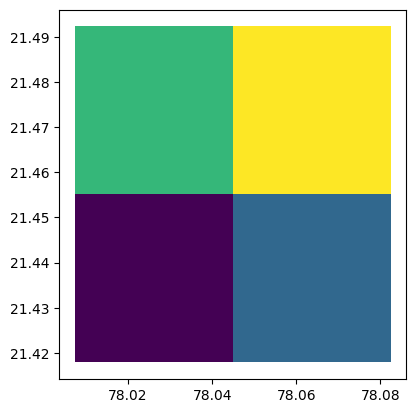

In [198]:
# convert to geodataframe
gdf = gpd.GeoDataFrame(geometry=polys, crs="EPSG:4326")

gdf = gdf.reset_index(drop=False).rename(columns={"index": "grid_id"})

gdf.plot(column='grid_id')

In [199]:
# write gdf as shapefile
gdf.to_file("polygons/polygons.shp", driver='ESRI Shapefile')

In [ ]:
# open geotiff files in folder tiffs_for_tests
da = rxr.open_rasterio("tiffs_for_tests/2023-01-02.tif")
  

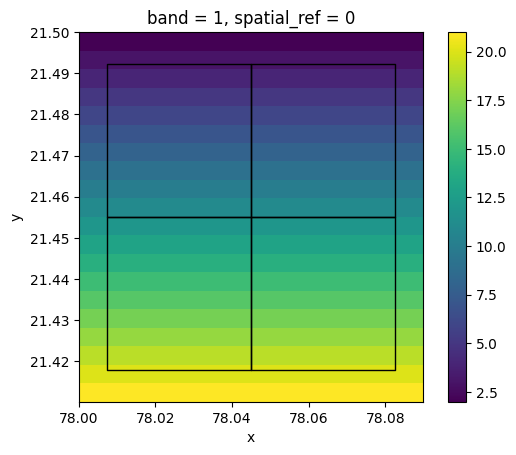

In [201]:
da.sel(band=1).plot()

# add polygons to the plot
ax = gdf.plot( color='none', edgecolor='black', ax=plt.gca())

In [202]:
da.band.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [203]:
# add to gdf column for band mean
for band in da.band.values:
    gdf[ f'B{band}_mean'] = None


# find all columns that start with 'B'
band_columns = [col for col in gdf.columns if col.startswith('B')]

# clip the raster to the polygons
for i, row in gdf.iterrows():
    
    clipped = da.rio.clip([row.geometry], gdf.crs, drop=True)

    gdf.loc[i, band_columns] = clipped.mean(dim=['x', 'y']).values


gdf

,grid_id,geometry,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,B10_mean,B11_mean
0,0,"POLYGON ((78.00741 21.41792, 78.04492 21.41792...",15.5,115.5,215.5,315.5,415.5,515.5,615.5,715.5,815.5,915.5,4.34375
1,1,"POLYGON ((78.04492 21.41792, 78.08242 21.41792...",15.5,115.5,215.5,315.5,415.5,515.5,615.5,715.5,815.5,915.5,4.375
2,2,"POLYGON ((78.00741 21.45509, 78.04492 21.45509...",7.5,107.5,207.5,307.5,407.5,507.5,607.5,707.5,807.5,907.5,4.46875
3,3,"POLYGON ((78.04492 21.45509, 78.08242 21.45509...",7.5,107.5,207.5,307.5,407.5,507.5,607.5,707.5,807.5,907.5,4.34375
